## Try to maximize the likelihood using iminuit (CMB parameterization)

See tutorials here: https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,
                                basedir=basedir,
                                skewers_label=skewers_label,
                                data_cov_factor=1)

Setup archive of P1D measurements from simulations to train the emulator

In [3]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup FullTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [5]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=emu.arxiv.get_simulation_cosmology(test_sim_num)
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    camb_model_sim=CAMB_model.CAMBModel(zs=data.z,cosmo=sim_cosmo)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_sim)
else:
    theory=full_theory.FullTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.camb_model_fid.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [6]:
# Likelihood parameters (option to fix cosmology)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[-0.2, 0.2],[-0.5, 0.5],[-0.2, 0.2]]
else:
    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05], [-0.2, 0.2],
            [-0.5, 0.5], [-0.2, 0.2]]

In [7]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5,
                            emu_cov_factor=1)

In [8]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
As = 1.9999999999999997e-09
ns = 0.9750000000000001
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
starting chi2 867.1294844094404


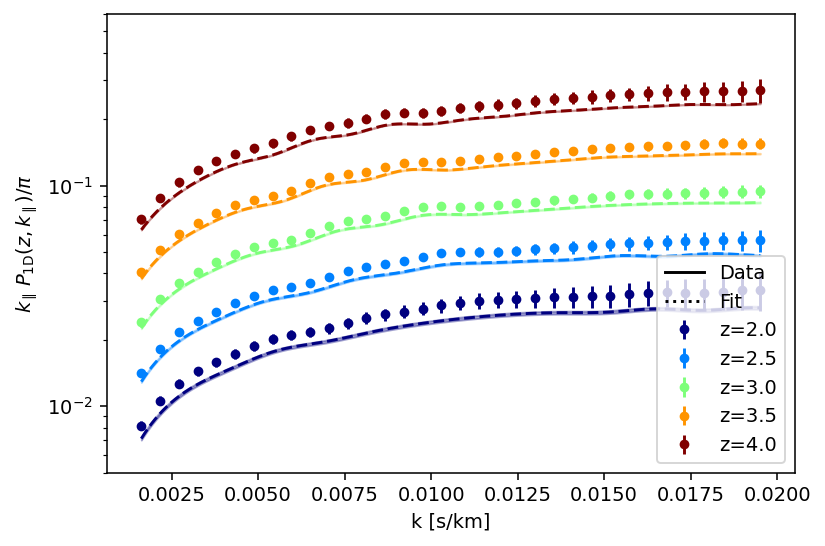

In [9]:
like.plot_p1d(plot_every_iz=2)

### Setup our own minimizer

In [10]:
import iminuit_minimizer

In [11]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,verbose=True)

best-fit values = [0.5 0.5 0.5 0.5 0.5]


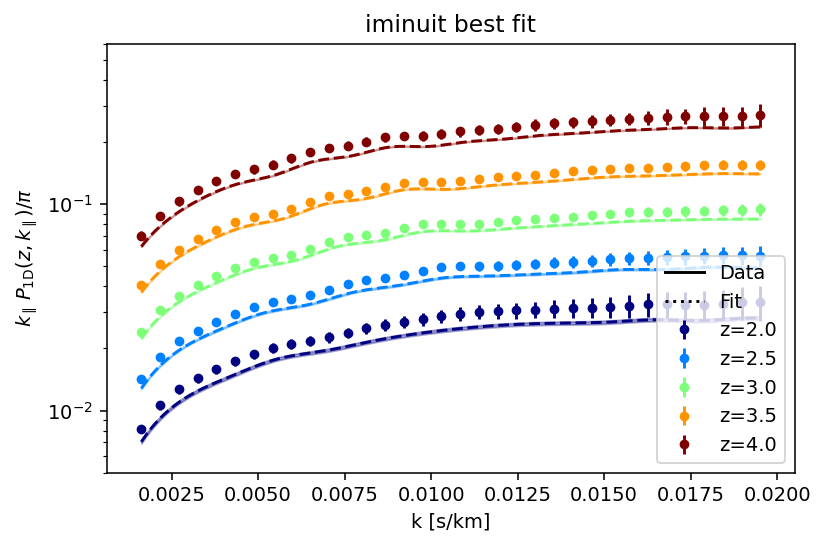

In [12]:
minimizer.plot_best_fit()

In [13]:
minimizer.minimize()

will run migrad


 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


will compute Hessian matrix


best-fit values = [0.3492085  0.42684807 0.75183294 0.42496927 0.24287664]


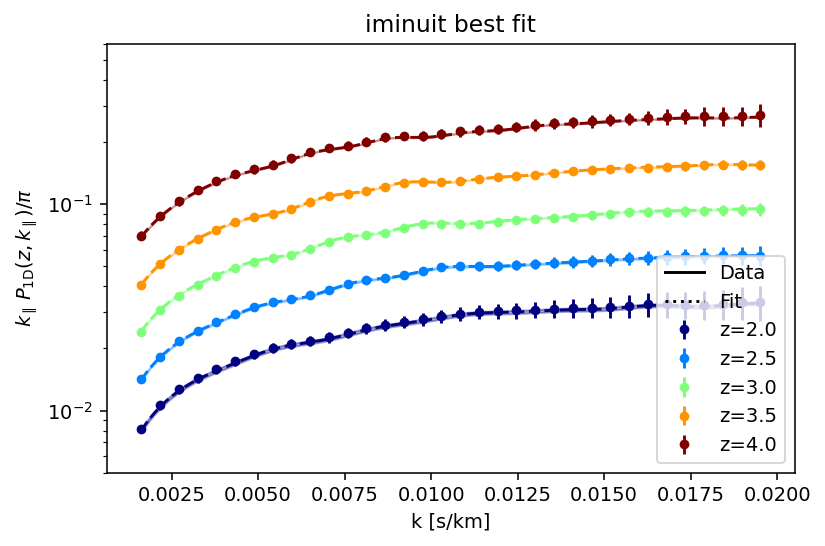

In [14]:
minimizer.plot_best_fit()

# Run iminuit minimiser

In [15]:
from iminuit import Minuit

In [16]:
# setup iminuit
m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)

In [17]:
# run optimiser
m.migrad()

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = 35.92                   |     Ncalls=337 (337 total)     |
| EDM = 1.41e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.349   |   0.027   |            |            |         |         |       |
| 1 | x1   |   0.43    |   0.04    |            |            |         |         |       |
| 2 | x2   |   0.752   |   0.021   |            |            |         |         |       |
| 3 | x3   |   0.42    |   0.14    |            |            |         |         |       |
| 4 | x4   |   0.24    |   0.08    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [18]:
# access results again
print('best fit values =',m.values)
m.get_fmin()

best fit values = <ValueView of Minuit at 7fa1d0af46d8>
  x0: 0.34920849750127403
  x1: 0.426848071353355
  x2: 0.751832937277931
  x3: 0.424969266017762
  x4: 0.24287663934607526


------------------------------------------------------------------
| FCN = 35.92                   |     Ncalls=337 (337 total)     |
| EDM = 1.41e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

In [19]:
min_chi2=like.get_chi2(m.values)
print('minimum chi2',min_chi2)
for par in like.parameters_from_sampling_point(m.values):
    print(par.info_str())

minimum chi2 5.379853562709941
As = 1.698416995002548e-09
ns = 0.9640272107030032
ln_tau_0 = 0.1007331749111724
ln_sigT_kms_0 = -0.07503073398223797
ln_gamma_0 = -0.1028493442615699


In [20]:
# compare to truth
sim_cosmo=emu.arxiv.get_simulation_cosmology(test_sim_num)
print('true As =',sim_cosmo.InitPower.As)
print('true ns =',sim_cosmo.InitPower.ns)

true As = 1.765434e-09
true ns = 0.965899


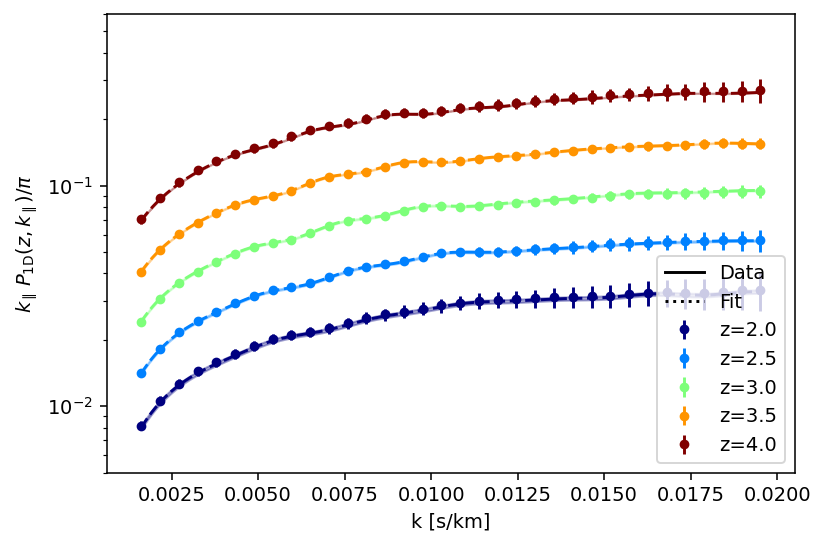

In [21]:
like.plot_p1d(plot_every_iz=2,values=m.values)

# Other cool things we can do with iminuit

In [22]:
# get Gaussian approximated errors
m.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.349   |   0.024   |            |            |         |         |       |
| 1 | x1   |   0.43    |   0.04    |            |            |         |         |       |
| 2 | x2   |   0.752   |   0.019   |            |            |         |         |       |
| 3 | x3   |   0.42    |   0.14    |            |            |         |         |       |
| 4 | x4   |   0.24    |   0.08    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [23]:
# get proper errors from likelihood scans
m.minos()

------------------------------------------------------------------------------------------------------------------------------------
|          |          x0           |          x1           |          x2           |          x3           |          x4           |
------------------------------------------------------------------------------------------------------------------------------------
|  Error   |  -0.026   |   0.028   |   -0.04   |   0.04    |  -0.023   |   0.021   |   -0.11   |   0.15    |   -0.07   |   0.11    |
|  Valid   |   True    |   True    |   True    |   True    |   True    |   True    |   True    |   True    |   True    |   True    |
| At Limit |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |
| Max FCN  |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |
| New Min  |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |   False   |
------------------------------------------------------------------------------------------------------------------------------------

In [24]:
# get best-fit values
m.np_values()

array([0.3492085 , 0.42684807, 0.75183294, 0.42496927, 0.24287664])

In [25]:
like.get_free_parameter_list()

['As', 'ns', 'ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0']

In [26]:
# get parameters covariance
m.np_covariance()

array([[ 0.00059986,  0.00021406, -0.00036846,  0.00046797,  0.0003201 ],
       [ 0.00021406,  0.00163167, -0.00039128,  0.00051228,  0.00055172],
       [-0.00036846, -0.00039128,  0.00036236, -0.00068739,  0.00012002],
       [ 0.00046797,  0.00051228, -0.00068739,  0.01831559,  0.0050516 ],
       [ 0.0003201 ,  0.00055172,  0.00012002,  0.0050516 ,  0.00691262]])

(array([0.3460602 , 0.36401306, 0.38196592, 0.39991878, 0.41787164,
        0.4358245 , 0.45377736, 0.47173022, 0.48968308, 0.50763594]),
 array([37.53858479, 36.95751952, 36.47714162, 36.12957977, 35.94607252,
        35.94639161, 36.12631838, 36.44898135, 36.86208843, 37.32034966]))

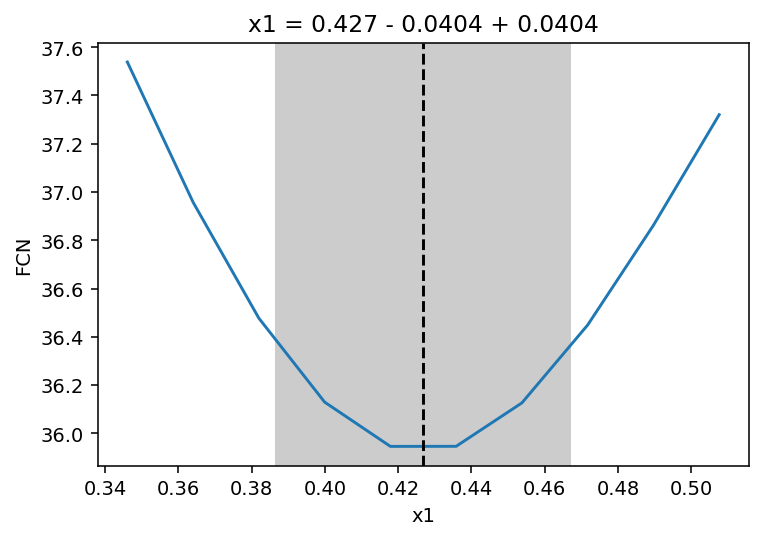

In [27]:
# scan one parameter and plot minus log posterior
m.draw_mnprofile(vname='x1',bins=10)

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


(array([0.15429909, 0.21444801, 0.27459694, 0.33474587, 0.3948948 ,
        0.45504373, 0.51519266, 0.57534159, 0.63549052, 0.69563945]),
 array([39.94406422, 38.20672978, 36.91924232, 36.20675938, 35.94858634,
        35.94536957, 36.10690344, 36.40316707, 36.82840412, 37.37851289]))

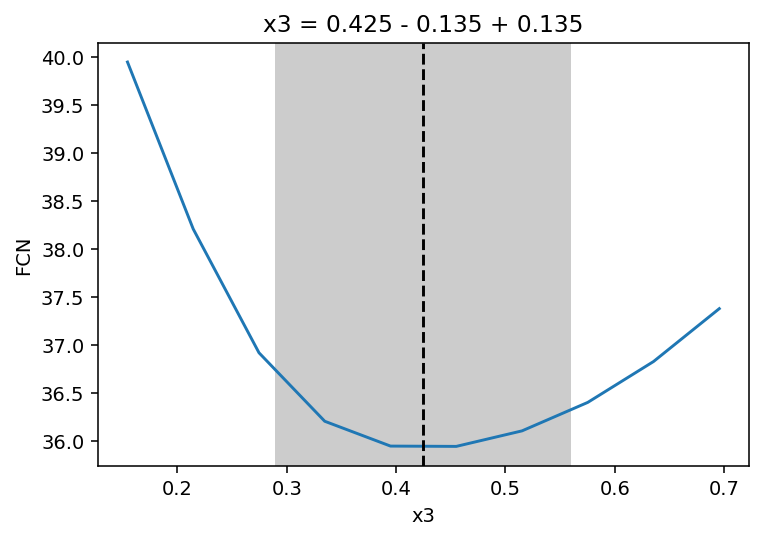

In [28]:
# for another parameter
m.draw_mnprofile(vname='x3',bins=10)

(array([0.30022448, 0.30538069, 0.3105369 , 0.31569311, 0.32084933,
        0.32600554, 0.33116175, 0.33631797, 0.34147418, 0.34663039,
        0.3517866 , 0.35694282, 0.36209903, 0.36725524, 0.37241145,
        0.37756767, 0.38272388, 0.38788009, 0.39303631, 0.39819252]),
 array([0.3460602 , 0.35456419, 0.36306817, 0.37157216, 0.38007615,
        0.38858013, 0.39708412, 0.40558811, 0.41409209, 0.42259608,
        0.43110006, 0.43960405, 0.44810804, 0.45661202, 0.46511601,
        0.47362   , 0.48212398, 0.49062797, 0.49913196, 0.50763594]),
 array([[1.30532612e+01, 1.25661120e+01, 1.20675082e+01, 1.15627924e+01,
         1.10578175e+01, 1.05588873e+01, 1.00726434e+01, 9.60585851e+00,
         9.16511379e+00, 8.75636168e+00, 8.38442568e+00, 8.05254613e+00,
         7.76214221e+00, 7.51298302e+00, 7.30389404e+00, 7.13393999e+00,
         7.00376323e+00, 6.91656562e+00, 6.87827400e+00, 6.89676089e+00],
        [1.17784418e+01, 1.12611872e+01, 1.07346370e+01, 1.02042014e+01,
         9.67

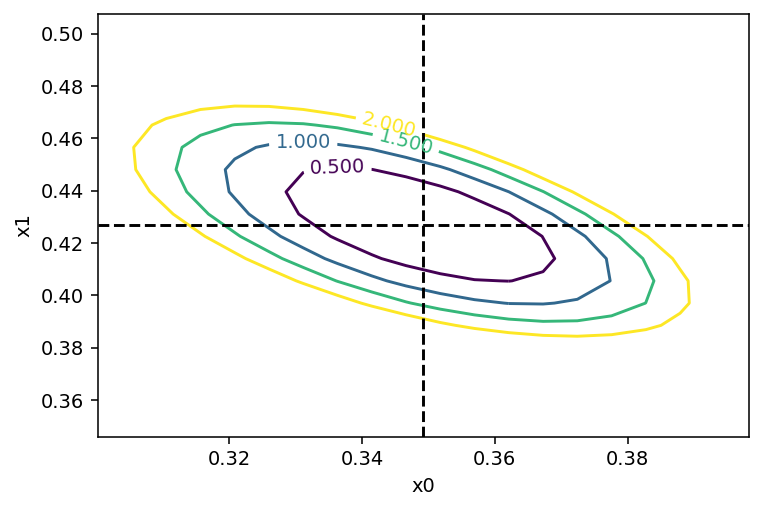

In [29]:
# 2D contours
m.draw_contour('x0','x1',bins=20)

In [30]:
# matrix correlations
m.matrix(correlation=True)

-------------------------------------------
|    |     x0     x1     x2     x3     x4 |
-------------------------------------------
| x0 |  1.000  0.216 -0.790  0.141  0.157 |
| x1 |  0.216  1.000 -0.509  0.094  0.164 |
| x2 | -0.790 -0.509  1.000 -0.267  0.076 |
| x3 |  0.141  0.094 -0.267  1.000  0.449 |
| x4 |  0.157  0.164  0.076  0.449  1.000 |
-------------------------------------------